In [1]:
from dateutil.parser import parse
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.rcParams.update({'figure.figsize':(10,7),'figure.dpi':120})

df=pd.read_csv('../Dollar-Carrot.csv')

In [2]:
df = df.reset_index()
df = df[['Date', 'Dambulla']]
df = df.set_index('Date')


df = df.reset_index()
df

,Date,Dambulla
0,2020-01-01,305.0
1,2020-01-02,272.5
2,2020-01-03,240.0
3,2020-01-04,207.5
4,2020-01-05,175.0
...,...,...
1454,2023-12-25,496.0
1455,2023-12-26,523.0
1456,2023-12-27,550.0
1457,2023-12-28,575.0


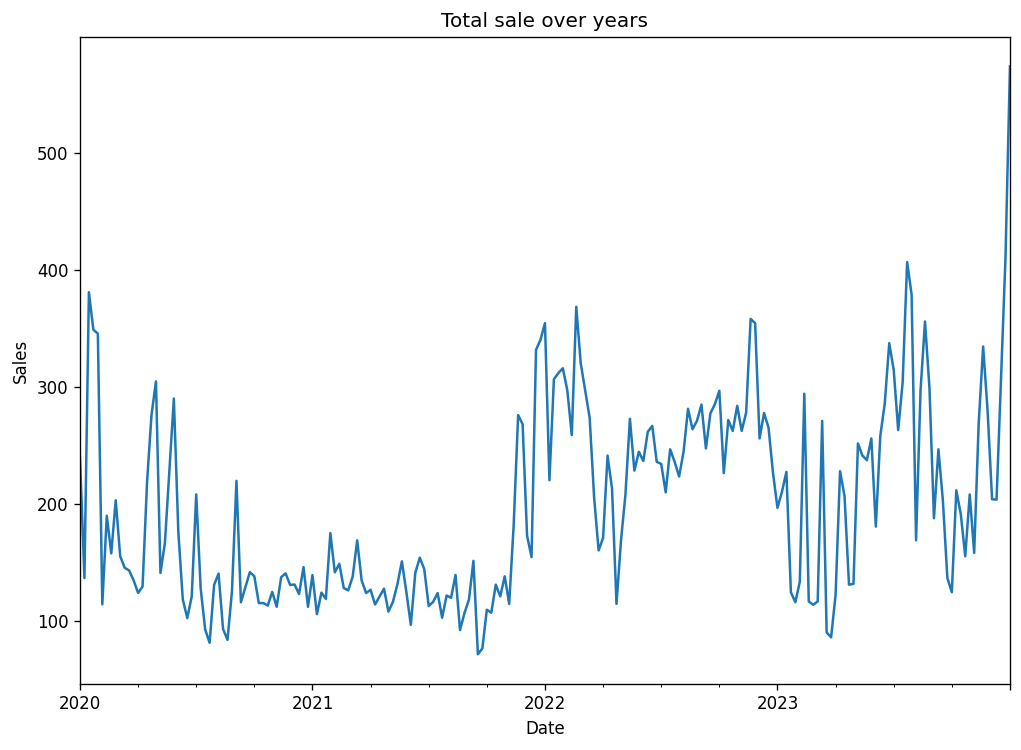

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df= df.set_index('Date')

df = df.resample('W').mean()
df = df.reset_index()
df.columns = ['Date', 'Dambulla']
df.set_index('Date', inplace=True)

df['Dambulla'].plot()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Total sale over years')
plt.show()

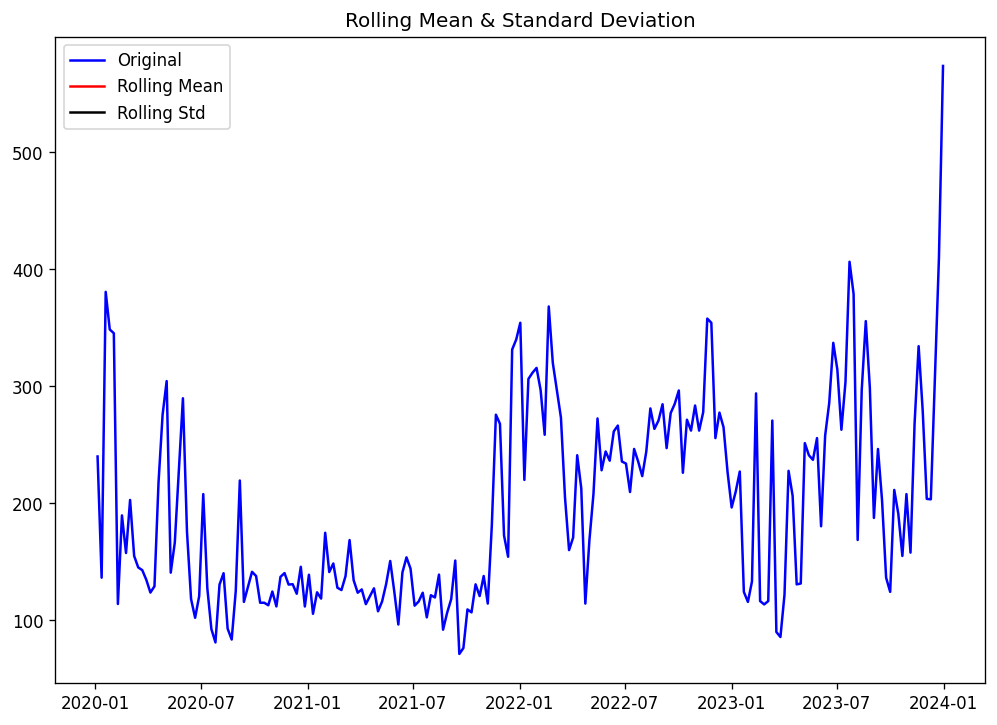

In [4]:

moving_avg = df.rolling(365).mean()
moving_std= df.rolling(365).std()
#Plot rolling statistics:
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
std = plt.plot(moving_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [5]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.322217
p-value                          0.164902
#Lags Used                       7.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


In [6]:
train_size = int(0.95 * len(df))

train = df[:train_size]
test = df[train_size:]

In [7]:
import pmdarima

from pmdarima import auto_arima
auto_arima(df,test='adf',       # use adftest to find optimal 'd'
                       # maximum p and q
                                 # frequency of series
                       # let model determine 'd'
                      seasonal=True,   # No Seasonality
                       

                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2256.679, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2313.589, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2308.574, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2294.248, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2311.727, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2285.557, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2277.591, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2244.943, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2243.666, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2244.733, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2243.937, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2295.046, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2243.038, Time=0.25 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2244.864, Time=0.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept

ARIMA(order=(4, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
import statsmodels.api as sm
model1=sm.tsa.statespace.SARIMAX(train,order=(4, 1, 0),seasonal_order=(4,1,0,52))

results=model1.fit()
results.summary()

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Dambulla   No. Observations:                  198
Model:             SARIMAX(4, 1, 0)x(4, 1, 0, 52)   Log Likelihood                -794.323
Date:                            Sun, 13 Oct 2024   AIC                           1606.647
Time:                                    16:08:38   BIC                           1633.438
Sample:                                01-05-2020   HQIC                          1617.533
                                     - 10-15-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3449      0.085     -4.053      0.000      -0.512      -0.178
ar.L2         -0.3984      0.079     -5.059      0.000      -0.553      -0.244
ar.L3         -0.4249      0.080     -5.314      0.000      -0.582      -0.268
ar.L4          0.1640      0.089      1.842      0.066      -0.011       0.339
ar.S.L52      -0.5173    195.333     -0.003      0.998    -383.363     382.328
ar.S.L104     -0.1033    128.898     -0.001      0.999    -252.739     252.532
ar.S.L156     -0.1624    642.553     -0.000      1.000   -1259.542    1259.218
ar.S.L208     -0.0090   1237.137  -7.31e-06      1.000   -2424.753    2424.735
sigma2      2927.7962   6.98e+04      0.042      0.967   -1.34e+05     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 6.30
Prob(Q):                              0.79   Prob(JB):                         0.04
Heteroskedasticity (H):               1.51   Skew:                            -0.44
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
pre=results.predict(start= len(train), end= (len(df)-1),dynamic=True)
pre

2023-10-22    154.926927
2023-10-29    144.631919
2023-11-05    185.422768
2023-11-12    220.262756
2023-11-19    294.513649
2023-11-26    259.997465
2023-12-03    189.658677
2023-12-10    197.876709
2023-12-17    286.443697
2023-12-24    246.976856
2023-12-31    240.845443
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [10]:
from  sklearn.metrics import mean_absolute_percentage_error

mape= mean_absolute_percentage_error(test, pre)

print('MAPE: %f' %mape)
from sklearn.metrics import root_mean_squared_error

# Calculate RMSE directly using root_mean_squared_error
rmse = root_mean_squared_error(test, pre)

# Print the RMSE
print('RMSE: %f' % rmse)
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(test, pre)

# Print the MAE
print('MAE: %f' % mae)
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Calculate RMSLE
rmsle = np.sqrt(mean_squared_log_error(test, pre))

# Print the RMSLE
print('RMSLE: %f' % rmsle)

MAPE: 0.180417
RMSE: 115.635260
MAE: 66.657412
RMSLE: 0.334401


In [11]:
test


,Dambulla
Date,
2023-10-22,155.000000
2023-10-29,207.857143
2023-11-05,157.857143
2023-11-12,267.857143
2023-11-19,334.285714
2023-11-26,279.285714
2023-12-03,203.750000
2023-12-10,203.392857
2023-12-17,306.428571


In [12]:
pre

2023-10-22    154.926927
2023-10-29    144.631919
2023-11-05    185.422768
2023-11-12    220.262756
2023-11-19    294.513649
2023-11-26    259.997465
2023-12-03    189.658677
2023-12-10    197.876709
2023-12-17    286.443697
2023-12-24    246.976856
2023-12-31    240.845443
Freq: W-SUN, Name: predicted_mean, dtype: float64

<Axes: xlabel='Date'>

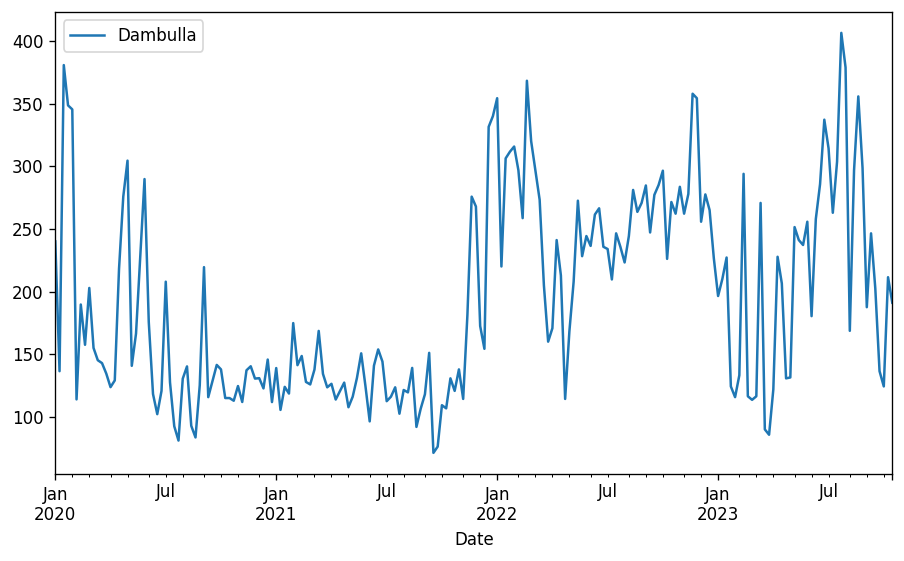

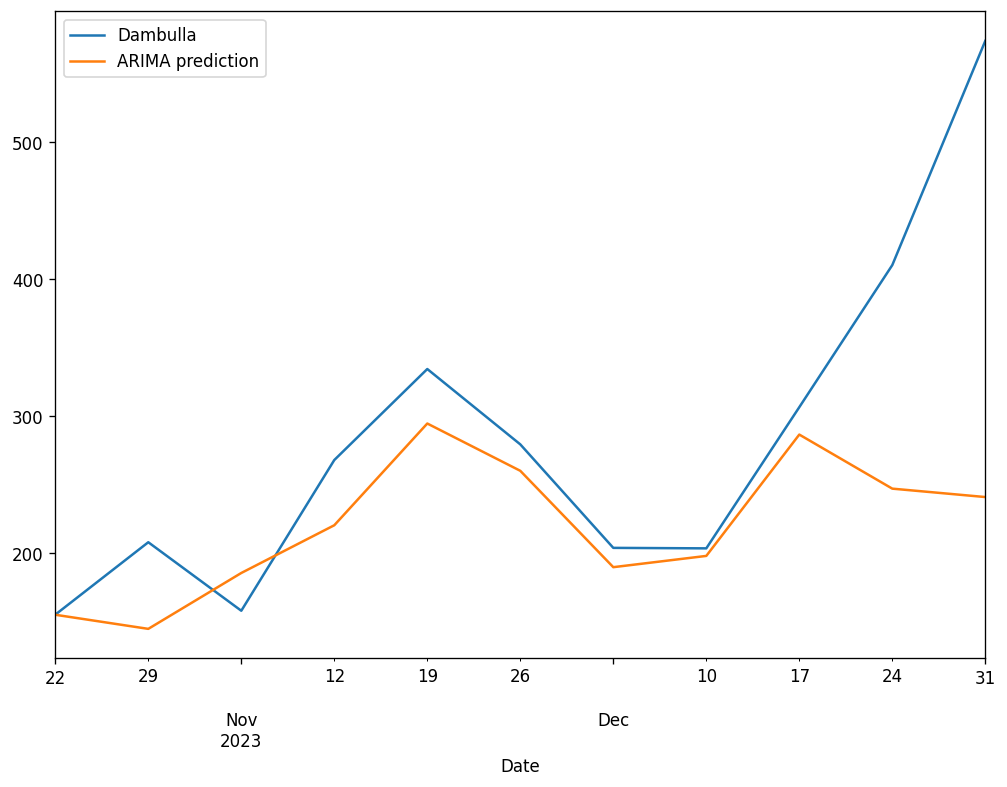

In [13]:
train.plot(legend=True, label='Train', figsize=(9,5))

test.plot(legend=True, label= 'Test')

pre.plot(legend=True, label='ARIMA prediction')